#Modeling with Mixed Datatypes using the Titanic Dataset

---

The RMS Titanic is a well known passenger ship that sank in 1912.  The [passenger list](https://www.kaggle.com/c/titanic/data) of the ship is a popular dataset of demographic information.

While most models predict likelihood of surviving the crash given demographic information, we will instead use the dataset to demonstrate how to work with mixed datatypes and combine likelihoods.

Let's set up our environment and load our data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from microscopes.models import dd as dirichlet_discrete
from microscopes.models import bb as beta_bernoulli
from microscopes.models import gp as gamma_poisson
from microscopes.models import nich as normal_inverse_chisquared
from sklearn.preprocessing import LabelEncoder as Encoder
from microscopes.mixture.definition import model_definition
from microscopes.common.rng import rng
from microscopes.common.recarray.dataview import numpy_dataview
from microscopes.mixture import model, runner, query
from microscopes.kernels import parallel
from microscopes.common.query import groups, zmatrix_heuristic_block_ordering, zmatrix_reorder
sns.set_context('talk')


%matplotlib inline

In [2]:
ti = sns.load_dataset('titanic')

Some of the columns in the data are reduntant, while others have missing data.  Let's ignore columns with lots of missing data, and focus on columns with key information.  We'll also drop rows with missing data.

In [3]:
unique_cols = ['survived','pclass','sex','age','sibsp','parch','fare']
to_cluster = ti[unique_cols].dropna()
print '%d passengers in dataset' % len(to_cluster.index)

714 passengers in dataset


For this example, we'll be using a Dirichlet Process Mixture Model to cluster the passengers

In this mixutre model, each column will have its own distributuion over values conditioned on the cluster assignment.  We must specify the distribution by selecting which likelihood we'd like to use for each column.

In [4]:
to_cluster.head()

,survived,pclass,sex,age,sibsp,parch,fare
0,0,3,male,22,1,0,7.2500
1,1,1,female,38,1,0,71.2833
2,1,3,female,26,0,0,7.9250
3,1,1,female,35,1,0,53.1000
4,0,3,male,35,0,0,8.0500


For modelling, we must encode all categorical data into integer values.  To do this we'll use [scikitlearn's LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [5]:
en1 = Encoder()
to_cluster['sex'] = en1.fit_transform(to_cluster['sex'])
to_cluster.head()

,survived,pclass,sex,age,sibsp,parch,fare
0,0,3,1,22,1,0,7.2500
1,1,1,0,38,1,0,71.2833
2,1,3,0,26,0,0,7.9250
3,1,1,0,35,1,0,53.1000
4,0,3,1,35,0,0,8.0500


To decide on which likelihood model to use on each column, let's get some basic statistics on our data

In [6]:
to_cluster.describe()

,survived,pclass,sex,age,sibsp,parch,fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.634454,29.699118,0.512605,0.431373,34.694514
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,1.000000,28.000000,0.000000,0.000000,15.741700
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200


The above data table gives us a good idea of what kinds of likelihoods to use for each column:

- `survived`, which indicates survival from the crash, is a binary column, which we will model with a beta-bernoulli distribution
- `pclass`, which is passenger class in the ship, ranges from 1 to 3.  This ordinal column we'll model with a gamma-poisson distribution
- `sex` is another binary column we can model as beta-bernoulli
- `age` is real valued, so we model this column as normally distributed
- `sibsp`, which is number of siblings/spouses on the ship, ranges from 1 to 5.  Since this data is integer valued and of limited range, we'll model this as also gamma-poisson.
- `parch`, which is number of parents/children on the ship, has similar characteristics to `sibsp` so it'll also be modeled gamma-poisson-
- `fare` is also real valued so we can model this as normal. However, the data is long tailed so we'll take the log of `fare` instead

We have two kinds of normal distributions, the normal inverse-wishart and the normal inverse-chi-square distribution.  To determine which model we should use, let's find the correlation between `age` and `logfare`

In [7]:
to_cluster['fare'] = np.log(to_cluster['fare'])

to_cluster[['age','fare']].corr()

,age,fare
age,1.000000,0.135352
fare,0.135352,1.000000


Since the correlation between `age` and `fare` is near 0, we can model these columns with a normal inverse-chi-square distribution

We'll now define our model using the `model_definition` function and run a gibbs sampler for 30000 iterations to learn the latent clusters

In [8]:
nchains = 1
iters = 30000
splits = 7

defn = model_definition(to_cluster.shape[0], [beta_bernoulli, gamma_poisson, beta_bernoulli, normal_inverse_chisquared, gamma_poisson, gamma_poisson, normal_inverse_chisquared]) 

prng = rng()

data_rec = np.array([(list(to_cluster.ix[c]),) for c in to_cluster.index], dtype=[('', np.float32, to_cluster.shape[1])])
view = numpy_dataview(data_rec)
latent = model.initialize(defn, view, prng)
rnr = runner.runner(defn, view, latent, kernel_config=['assign'])

rnr.run(r=prng, niters=iters)

In [9]:
assignments = rnr.get_latent().assignments()

In [10]:
clusters = list(set(assignments))
K = len(clusters)

'%d clusters inferred' % K

'7 clusters inferred'

In [11]:
to_cluster['cluster'] = assignments

Now that we have our cluster assignments, let's plot the posterior distributions over each column in the data

Since `survived`, `pclass`, `sex`, `sibsp`, and `parch` have few observed values, we can plot these with bar graphs

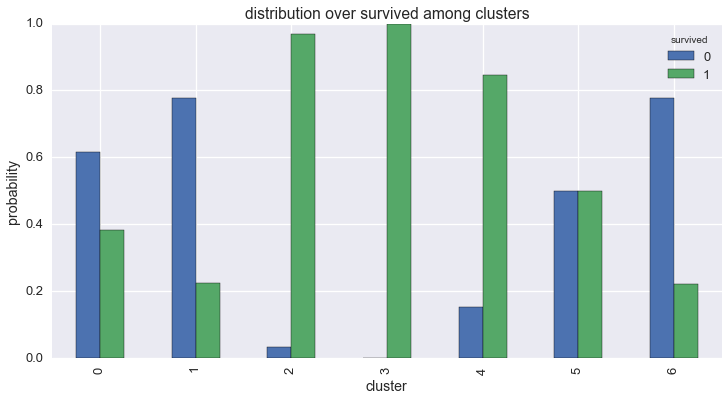

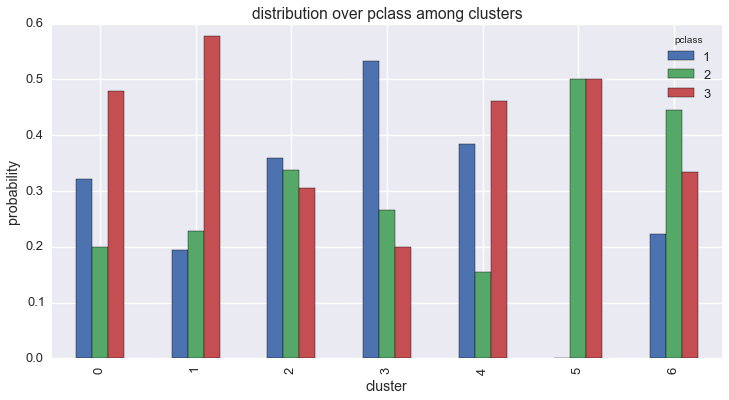

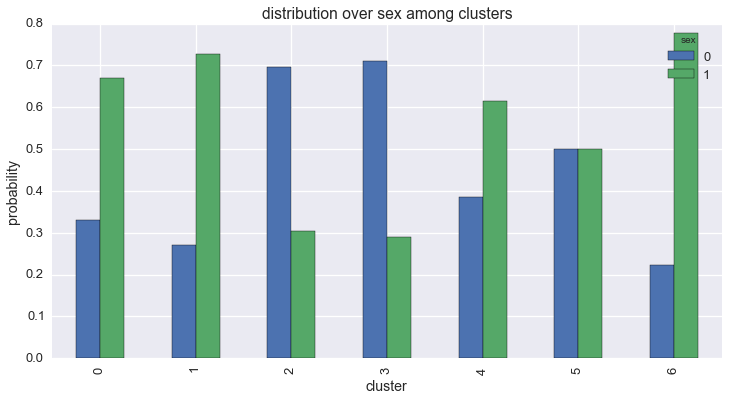

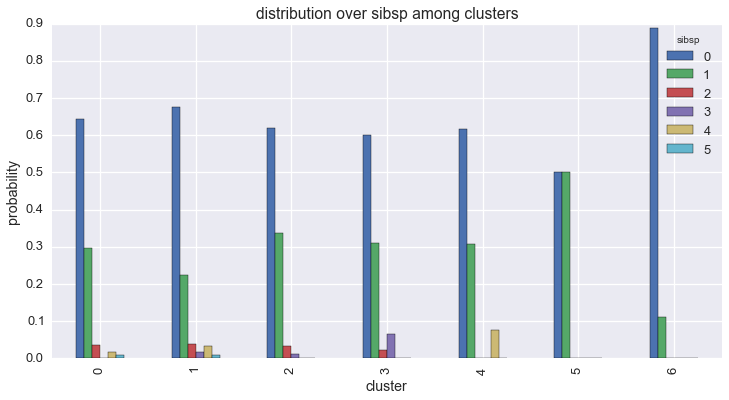

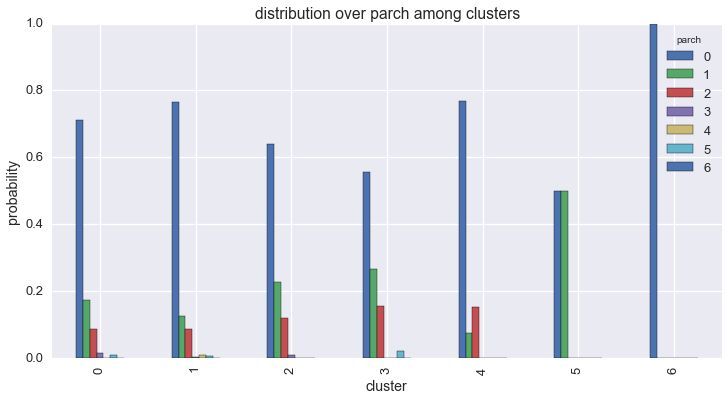

In [19]:
for c in ['survived', 'pclass', 'sex', 'sibsp', 'parch']:
    dist = to_cluster.groupby(['cluster', c])['age'].count()/to_cluster.groupby('cluster')['age'].count()
    dist.unstack().plot(kind='bar', figsize=(12,6))
    plt.title('distribution over %s among clusters' % c)
    plt.ylabel('probability')
    plt.xticks(range(K), range(K))

Each of the clusters have their own distribution over values, as shown by the plots

Let's now plot the columns we've modeled as normal inverse-chi-squared, `age` and `fare`, with a kernel density estimate

Recall that we've transformed `fare` into $\text{ln(fare)}$

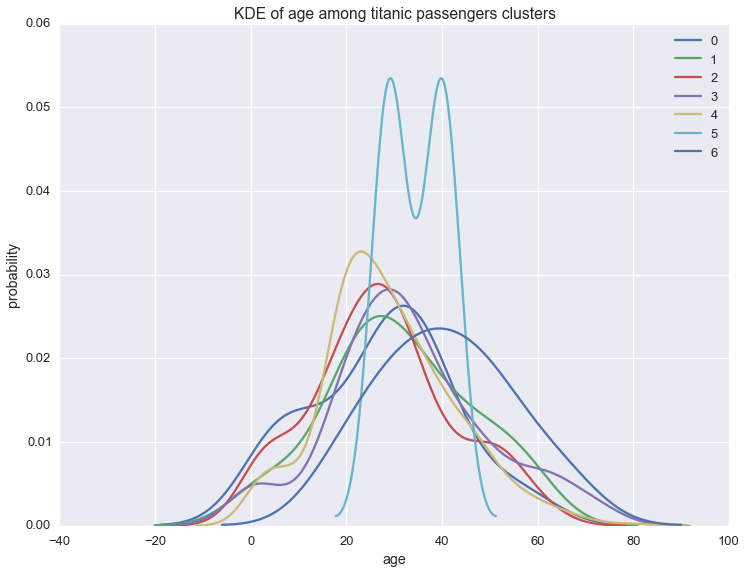

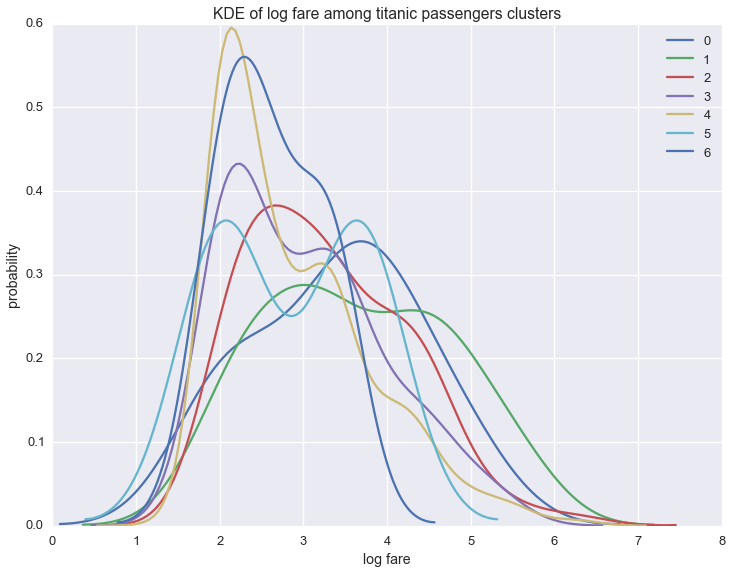

In [18]:
for c in ['age', 'fare']:
    plt.figure(figsize=(12,9))
    for k in clusters:
        sns.kdeplot(to_cluster.loc[to_cluster['cluster'] == k, c], legend = False)
    if c == 'fare':
        c = 'log fare'
    plt.title('KDE of %s among titanic passengers clusters' % c)
    plt.ylabel('probability')
    plt.legend(range(K))
    plt.xlabel(c)